In [1]:
__depends__ = ["../results/human_averages.csv", "../results/model.csv"]
__dest__ = ["../figures/model_v_human.pdf", "../results/model_v_human.tex"]

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import util

In [3]:
# Load in the human data
human = pd.read_csv(__depends__[0]).set_index('stimulus').sortlevel()
human.head()

/u/49/tewodrod/unix/spike/nbflow-example/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  


,x,lower,median,upper,mean,lerr,uerr
stimulus,,,,,,,
0,0.000000,0.008356,0.011539,0.015389,0.011696,0.003340,0.003694
1,0.028571,0.009862,0.012827,0.016178,0.012913,0.003051,0.003265
2,0.057143,0.014842,0.018581,0.023324,0.018709,0.003866,0.004616
3,0.085714,0.020169,0.026024,0.033465,0.026261,0.006093,0.007204
4,0.114286,0.027964,0.035505,0.045211,0.035916,0.007953,0.009295


In [4]:
# Load in the model data
model = pd.read_csv(__depends__[1]).set_index('stimulus').sortlevel()
model.head()

/u/49/tewodrod/unix/spike/nbflow-example/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  


,x,y
stimulus,,
0,0.000000,0.246047
1,0.028571,0.263991
2,0.057143,0.276916
3,0.085714,0.304670
4,0.114286,0.311580


In [5]:
# Fit the model to the human data using logistic regression
def f(beta):
    yp = util.sigmoid(model["y"], beta)
    err = np.sqrt(np.sum((yp - human["mean"]) ** 2))
    return err

res = scipy.optimize.minimize_scalar(f)
beta = res['x']
beta

16.888968071635986

In [6]:
# Compute predictions for the fitted model
fitted_model = util.sigmoid(model["y"], beta)
fitted_model.head()

stimulus
0    0.013533
1    0.018236
2    0.022584
3    0.035608
4    0.039840
Name: y, dtype: float64

In [7]:
# Compute the correlation between the raw model results and average human responses
corrs = util.bootcorr(model["y"], human["mean"])
corrs.head()

lower     0.966323
median    0.976619
upper     0.984866
corr      0.976249
dtype: float64

In [8]:
# Compute the correlation between the fitted model results and the average human responses
fitted_corrs = util.bootcorr(fitted_model, human["mean"])
fitted_corrs.head()

lower     0.992130
median    0.996184
upper     0.998541
corr      0.996003
dtype: float64

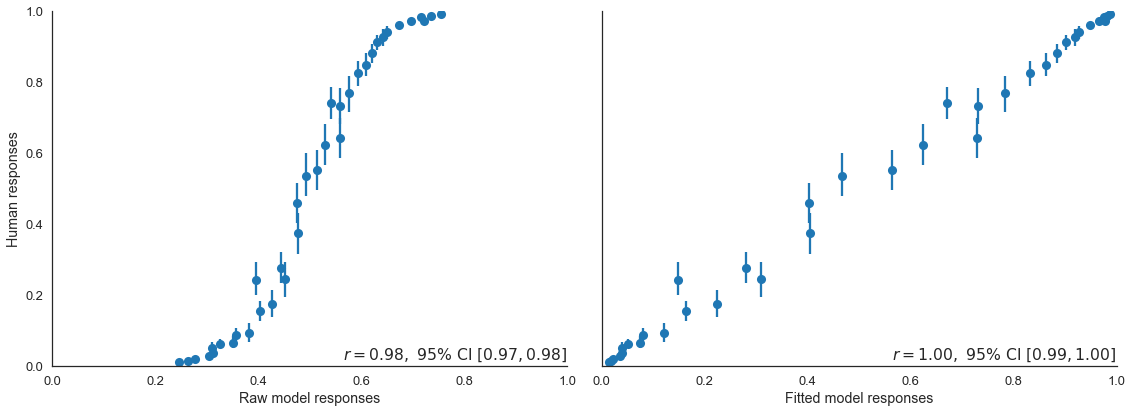

In [9]:
# Plot both the raw and fitted models against human data
sns.set_style("white")
sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.errorbar(
    model["y"], human["mean"], 
    yerr=[human["lerr"],  human["uerr"]], 
    marker='o', linestyle='')
ax1.set_xlabel("Raw model responses")
ax1.set_ylabel("Human responses")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
corrstr = r"$r={corr:.2f},\ 95\%\ \mathrm{{CI}}\ [{lower:.2f}, {upper:.2f}]$".format(**corrs)
ax1.text(1, 0.02, corrstr, horizontalalignment='right')

ax2.errorbar(
    fitted_model, human["mean"], 
    yerr=[human["lerr"],  human["uerr"]], 
    marker='o', linestyle='')
ax2.set_xlabel("Fitted model responses")
ax2.set_xlim(0, 1)
corrstr = r"$r={corr:.2f},\ 95\%\ \mathrm{{CI}}\ [{lower:.2f}, {upper:.2f}]$".format(**fitted_corrs)
ax2.text(1, 0.02, corrstr, horizontalalignment='right')

sns.despine()
fig.set_size_inches(16, 6)
plt.tight_layout()
plt.savefig(__dest__[0])

In [10]:
# Save out the correlations and fitted parameter values 
# as LaTeX commands for use in the paper
def newcommand(name, val):
    fmt = "\\newcommand{{\\{name}}}[0]{{{action}}}"
    cmd = fmt.format(name=name, action=val)
    print(cmd)
    return cmd + "\n"

latex_pearsonr = r"r={corr:.2f},\ 95\%\ \mathrm{{CI}}\ [{lower:.2f}, {upper:.2f}]"
latex_beta = r"\beta={beta:.2f}"

cmds = [
    newcommand(
        "ModelVHumanCorr",
        latex_pearsonr.format(**corrs)),
    newcommand(
        "FittedModelVHumanCorr",
        latex_pearsonr.format(**fitted_corrs)),
    newcommand(
        "FittedBeta",
        latex_beta.format(beta=beta))
]

with open(__dest__[1], "w") as fh:
    for cmd in cmds:
        fh.write(cmd)

\newcommand{\ModelVHumanCorr}[0]{r=0.98,\ 95\%\ \mathrm{CI}\ [0.97, 0.98]}
\newcommand{\FittedModelVHumanCorr}[0]{r=1.00,\ 95\%\ \mathrm{CI}\ [0.99, 1.00]}
\newcommand{\FittedBeta}[0]{\beta=16.89}
